In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from functools import partial
import itertools
from sklift.models import ClassTransformation
import lightgbm as lgbm
import ipywidgets as widgets
import inspect
from datetime import timedelta
from sklearn import preprocessing
import gc

In [2]:
import logging

# create logger
logger = logging.getLogger('lg')
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
logger.info('info message')

2020-01-27 23:46:09,073 - lg - INFO - info message


# Utils

In [4]:
def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)

    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()

    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()

    score = treatment_p - control_p
    return score


def get_train_test(features, df_train, df_test):
    return features.loc[df_train.index, :], features.loc[df_test.index, :]

In [5]:
def balance_learn(X_learn, y_learn):
    _, treatment_counts = np.unique(y_learn.treatment_flg, return_counts=True)
    logger.info("{}, {}, {}".format(X_learn.shape, y_learn.shape, treatment_counts[0] - treatment_counts[1]))
    
    treat_learn = y_learn.treatment_flg
    vc = treat_learn.value_counts()
    treat_learn = pd.concat([treat_learn[treat_learn == i].sample(vc.min()) for i in vc.index])

    X_learn = X_learn.loc[treat_learn.index, :]
    y_learn = y_learn.loc[treat_learn.index, :]
    
    _, treatment_counts = np.unique(y_learn.treatment_flg, return_counts=True)
    logger.info("{}, {}, {}".format(X_learn.shape, y_learn.shape, treatment_counts[0] - treatment_counts[1]))
    return X_learn, y_learn

In [6]:
def uplift_score_func(y_true, y_pred, **kwargs):
    return uplift_score(y_pred, treatment=y_true.treatment_flg, target=y_true.target)

In [7]:
class MyClassTransformation(ClassTransformation):
    def fit(self, X, y, estimator_fit_params=None):
        return  super().fit(X, y=y.target, treatment=y.treatment_flg, estimator_fit_params=estimator_fit_params)

In [8]:
def merge_transactions_and_products(products, transactions):
    columns = ['level_' + str(i) for i in range(1,5)] + ['brand_id', 'vendor_id', 'product_id', 'segment_id']
    transactions_with_products = transactions.merge(products, left_on='product_id', right_index=True)
    logger.info('transactions_with_products')
#     for col in columns:
#         fg = transactions_with_products.drop_duplicates(subset=['client_id', col]) \
#                                        .groupby([col]).size().sort_values(ascending=False)
#         fg.name = 'popularity_{}'.format(col)
#         transactions_with_products = transactions_with_products.join(fg, on=col)
#         logger.info('popularity {}'.format(col))
    return transactions_with_products

In [9]:
def get_transactions(df_purchases, offset=None):
    if not offset:
        return df_purchases

    last_date = df_purchases.date.max()    
    sub_df_purchases = df_purchases[df_purchases.date > last_date-timedelta(days=offset)]
    logger.info("sub_df_purchases shape : {}".format(sub_df_purchases.shape))
    return sub_df_purchases

In [10]:
BASE_TRANSACTION_TEMPLATE = 'base_transaction'
FAVORITES_TEMPLATE = 'favorites'
STEPS_MAPPING = {
    'BASE': (True, 'base_features.csv'),
    'BASE_TRANSACTION': (True, BASE_TRANSACTION_TEMPLATE),
    'FAVORITES': (True, FAVORITES_TEMPLATE),
}

In [11]:
def generate_file_name(prefix, offset):
    return '{}_{}.csv'.format(prefix, str(offset))

In [12]:
def get_features_from_files(offsets):
    features = pd.read_csv(STEPS_MAPPING['BASE'][1], index_col='client_id')
    
    base_trans_array = []
    for offset in offsets:
        offset = offset or ''
        base_trans_array.append(pd.read_csv(generate_file_name(STEPS_MAPPING['BASE_TRANSACTION'][1], offset), 
                                 index_col='client_id'))
    
    for df in base_trans_array:
        features = features.merge(df, left_index=True, right_index=True)
        del df

    gc.collect()
    favorites_array = []
    for offset in offsets:
        offset = offset or ''
        favorites_array.append(pd.read_csv(generate_file_name(STEPS_MAPPING['FAVORITES'][1], offset), 
                                           index_col='client_id'))
    
    for df in favorites_array:
        features = features.merge(df, left_index=True, right_index=True)
        del df
    gc.collect()
        
    return features

# Чтение данных

In [13]:
df_clients = pd.read_csv('data/clients.csv', index_col='client_id', parse_dates=['first_issue_date','first_redeem_date'])
logger.info(df_clients.shape)
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
logger.info(df_train.shape)
df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')
logger.info(df_test.shape)

df_products = pd.read_csv('data/products.csv', index_col='product_id')
logger.info(df_products.shape)

# df_purchases = pd.read_csv('data/purchases.csv', index_col='transaction_id', parse_dates=['transaction_datetime'], nrows=100000)
df_purchases = pd.read_csv('data/purchases.csv', index_col='transaction_id', parse_dates=['transaction_datetime'])
df_purchases['date'] = df_purchases['transaction_datetime'].dt.date

2020-01-27 23:46:11,058 - lg - INFO - (400162, 4)
2020-01-27 23:46:11,225 - lg - INFO - (200039, 2)
2020-01-27 23:46:11,370 - lg - INFO - (200123, 0)
2020-01-27 23:46:11,473 - lg - INFO - (43038, 10)


In [14]:
def base_features(clients, clean=True):
    df_features = clients.copy()
    df_features['gender'] = LabelEncoder().fit_transform(df_features.gender)
    df_features['first_issue_time'] = pd.to_datetime(df_features['first_issue_date']).astype(int) / 10 ** 9
    df_features['first_redeem_time'] = pd.to_datetime(df_features['first_redeem_date']).astype(int) / 10 ** 9
    df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
    df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)
    if STEPS_MAPPING['BASE'][0]:
        df_features.to_csv(STEPS_MAPPING['BASE'][1])
    
    if clean:
        del df_features
        gc.collect()
        return

    return df_features

In [15]:
def transactions_features(transactions, offset=None, clean=True):
    offset = offset or ''
    last_cols = [
        'regular_points_received', 
        'express_points_received',
        'regular_points_spent',
        'express_points_spent',
        'purchase_sum'
    ]

    logger.info("Create history")
    history = transactions.groupby(['client_id', 'transaction_id'])[last_cols].last()
    
    logger.info("Create _features")
    _features = [
        (history.groupby('client_id')['purchase_sum'].count(), ['total_trans_count']), 
        (history.groupby('client_id').sum(), last_cols)
    ]
    
    _features = list(zip(*_features))
    transactions_features =  pd.concat(_features[0], axis = 1)
    transactions_features.columns = list(itertools.chain.from_iterable(_features[1]))
    transactions_features.columns = ['days_{}_'.format(str(offset)) + c for c in transactions_features.columns]
    if STEPS_MAPPING['BASE_TRANSACTION'][0]:
        transactions_features.to_csv(generate_file_name(STEPS_MAPPING['BASE_TRANSACTION'][1], offset))
    
    if clean:
        del transactions_features
        gc.collect()
        return

    
    return transactions_features

In [16]:
def favorite_products_features(merged_transactions, offset=None, clean=True):

    offset = offset or ''
    # вычисляем любимый продукт/категорию/сегмент для каждого юзера.
    cols = ['product_id', 'brand_id', 'vendor_id', 'segment_id']
    result = []
    for c in cols:
        logger.info("favorite {}".format(c))
        result.append(
            merged_transactions.groupby(['client_id', c]).size().reset_index(name='counts').groupby(['client_id']).max()[c]
        )

    favorites = pd.concat(result, axis=1, sort=False)
    favorites.columns = [str(offset) + '_faivorite_' + c for c in cols]
    favorites.index.name = 'client_id'

    for col in favorites.columns:
        logger.info('LabelEncoder for {}'.format(col))
        favorites[col] = LabelEncoder().fit_transform(favorites[col].astype(str))    

    if STEPS_MAPPING['FAVORITES'][0]:
        favorites.to_csv(generate_file_name(STEPS_MAPPING['FAVORITES'][1], offset))

    if clean:
        del favorites
        gc.collect()
        return        
        
    return favorites

In [17]:
def generate_the_first_part_of_features(offset, df_products, df_purchases):
    sb_df_purchases = get_transactions(df_purchases, offset=offset)
    transactions_features(sb_df_purchases, offset=offset)
    sb_df_purchases = merge_transactions_and_products(df_products, sb_df_purchases)
    favorite_products_features(merged_transactions=sb_df_purchases, offset=offset)

In [18]:
base_features(df_clients);

In [18]:
offets = [None]
for offst in offets:
    logger.info('{} offst = {}'.format('--'*30, offst))
    generate_the_first_part_of_features(offst, df_products, df_purchases);

2020-01-27 23:48:23,815 - lg - INFO - ------------------------------------------------------------ offst = None
2020-01-27 23:48:23,816 - lg - INFO - sub_df_purchases shape : (45786568, 13)
2020-01-27 23:48:23,817 - lg - INFO - Create history
2020-01-27 23:49:15,420 - lg - INFO - Create _features
2020-01-27 23:50:26,859 - lg - INFO - transactions_with_products
2020-01-27 23:50:26,860 - lg - INFO - favorite product_id
2020-01-27 23:54:56,765 - lg - INFO - favorite brand_id
2020-01-27 23:58:37,200 - lg - INFO - favorite vendor_id
2020-01-28 00:02:12,891 - lg - INFO - favorite segment_id
2020-01-28 00:02:34,688 - lg - INFO - LabelEncoder for _faivorite_product_id
2020-01-28 00:02:34,789 - lg - INFO - LabelEncoder for _faivorite_brand_id
2020-01-28 00:02:34,866 - lg - INFO - LabelEncoder for _faivorite_vendor_id
2020-01-28 00:02:34,940 - lg - INFO - LabelEncoder for _faivorite_segment_id


In [19]:
offets = [14, 30, None]
features = get_features_from_files(offets)

In [20]:
features.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,days_14_total_trans_count,days_14_regular_points_received,days_14_express_points_received,days_14_regular_points_spent,days_14_express_points_spent,...,14_faivorite_vendor_id,14_faivorite_segment_id,30_faivorite_product_id,30_faivorite_brand_id,30_faivorite_vendor_id,30_faivorite_segment_id,_faivorite_product_id,_faivorite_brand_id,_faivorite_vendor_id,_faivorite_segment_id
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45,2,1.501948e+09,1.515094e+09,1.314656e+07,2,10.0,0.0,0.0,0.0,...,1737,53,11509,2309,1547,53,6270,1610,972,87
000036f903,72,0,1.491832e+09,1.492951e+09,1.118613e+06,3,4.1,0.0,0.0,0.0,...,1646,88,11768,2130,1454,88,6667,1678,1036,89
000048b7a6,68,0,1.544881e+09,-9.223372e+09,-1.076825e+10,1,1.2,0.0,0.0,0.0,...,413,30,4680,1622,327,30,6324,1523,1068,86
000073194a,60,0,1.495544e+09,1.511522e+09,1.597811e+07,1,1.3,0.0,0.0,0.0,...,1665,42,10696,1938,1537,87,5432,1540,962,86
00007f9014,45,0,1.503409e+09,1.550258e+09,4.684946e+07,2,3.3,0.0,0.0,0.0,...,1578,83,9903,2395,1385,83,6299,1698,807,87


In [21]:
x_train, x_test = get_train_test(features, df_train, df_test)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [22]:
x_train.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,days_14_total_trans_count,days_14_regular_points_received,days_14_express_points_received,days_14_regular_points_spent,days_14_express_points_spent,...,14_faivorite_vendor_id,14_faivorite_segment_id,30_faivorite_product_id,30_faivorite_brand_id,30_faivorite_vendor_id,30_faivorite_segment_id,_faivorite_product_id,_faivorite_brand_id,_faivorite_vendor_id,_faivorite_segment_id
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45.0,2.0,1.501948e+09,1.515094e+09,13146559.0,2.0,10.0,0.0,0.0,0.0,...,1737.0,53.0,11509.0,2309.0,1547.0,53.0,6270.0,1610.0,972.0,87.0
000036f903,72.0,0.0,1.491832e+09,1.492951e+09,1118613.0,3.0,4.1,0.0,0.0,0.0,...,1646.0,88.0,11768.0,2130.0,1454.0,88.0,6667.0,1678.0,1036.0,89.0
00010925a5,83.0,2.0,1.532449e+09,1.536942e+09,4492280.0,4.0,5.8,0.0,0.0,0.0,...,1578.0,91.0,11028.0,2375.0,1473.0,91.0,6489.0,1678.0,905.0,90.0
0001f552b0,33.0,0.0,1.498850e+09,1.535461e+09,36610747.0,4.0,44.7,0.0,0.0,0.0,...,1852.0,84.0,11027.0,2435.0,1668.0,88.0,7037.0,1740.0,1102.0,89.0
00020e7b18,73.0,2.0,1.511783e+09,1.515607e+09,3823700.0,2.0,15.6,0.0,-58.0,-10.0,...,1737.0,90.0,11840.0,2408.0,1622.0,90.0,6767.0,1743.0,1052.0,89.0


In [23]:
indices_learn, indices_valid = train_test_split(x_train.index, test_size=0.3)

In [24]:
X_learn = x_train.loc[indices_learn, :]
y_learn = df_train.loc[indices_learn, :]

X_val = x_train.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, :]

In [25]:
params = {'learning_rate':0.03,'max_depth':4,'num_leaves':20, 'n_estimators':501,
             'min_data_in_leaf':3, 'application':'binary', 'subsample':0.8, 'colsample_bytree': 0.8,
             'reg_alpha':0.01,'data_random_seed':42,'metric':'binary_logloss',
             'max_bin':416,'bagging_freq':3,'reg_lambda':0.01,'num_leaves':20             
    }

In [26]:
from sklearn.metrics import make_scorer
# models = list(map(lambda x: MyClassTransformation(x), [lgbm.LGBMClassifier(), lgbm.LGBMClassifier(**params)]))
# parameters = {'classifier__estimator__learning_rate': [0.03, 0.02]}
modelcv = GridSearchCV(
    Pipeline(steps=[
        ('classifier', MyClassTransformation(lgbm.LGBMClassifier(**params)))
    ]),
    {},
    scoring=make_scorer(uplift_score_func), 
    cv=ShuffleSplit(n_splits=4, test_size=0.3, random_state=12), 
    verbose=3, n_jobs=-1
)
modelcv.fit(X_learn, y_learn);

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.4s finished
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  app.launch_new_instance()


In [27]:
modelcv.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 MyClassTransformation(estimator=LGBMClassifier(application='binary',
                                                                bagging_freq=3,
                                                                boosting_type='gbdt',
                                                                class_weight=None,
                                                                colsample_bytree=0.8,
                                                                data_random_seed=42,
                                                                importance_type='split',
                                                                learning_rate=0.03,
                                                                max_bin=416,
                                                                max_depth=4,
                                                                metric='binary_logloss',
                         

In [28]:
modelcv.best_score_

0.07683267739634703

In [29]:
final_model = modelcv.best_estimator_

In [30]:
print('Validation score:', uplift_score(final_model.predict(X_val), treatment=y_val.treatment_flg, target=y_val.target))

Validation score: 0.056538169321969645


In [41]:
scores = cross_val_score(
    final_model, x_train, df_train,
    cv=ShuffleSplit(n_splits=20, test_size=0.3), 
    scoring=make_scorer(uplift_score_func)
)
scores

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  app.launch_new_instance()


array([0.06293154, 0.06284826, 0.07162569, 0.07804779, 0.08125949,
       0.10220153, 0.07829473, 0.09160986, 0.05951122, 0.06787641,
       0.0828996 , 0.06184032, 0.08472047, 0.06433467, 0.06075892,
       0.08813748, 0.05789038, 0.05606996, 0.06585884, 0.07159273])

### вычислим доверительный интервал оценки прогноза, чтобы по Public отсеживать overfit 

In [42]:
import scipy.stats as st 

In [43]:
np.mean(scores), st.sem(scores)

(0.07251549450233942, 0.002861956776746771)

In [44]:
st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)) 

(0.06652535012593169, 0.07850563887874715)

# Подготовка предсказаний для тестовых клиентов

In [35]:
x_train, df_train = balance_learn(x_train, df_train)

2020-01-28 00:05:17,364 - lg - INFO - (200039, 35), (200039, 2), 77
2020-01-28 00:05:17,662 - lg - INFO - (199962, 35), (199962, 2), 0


In [36]:
final_model.fit(x_train, df_train)

Pipeline(memory=None,
         steps=[('classifier',
                 MyClassTransformation(estimator=LGBMClassifier(application='binary',
                                                                bagging_freq=3,
                                                                boosting_type='gbdt',
                                                                class_weight=None,
                                                                colsample_bytree=0.8,
                                                                data_random_seed=42,
                                                                importance_type='split',
                                                                learning_rate=0.03,
                                                                max_bin=416,
                                                                max_depth=4,
                                                                metric='binary_logloss',
                         

In [37]:
upl_sc = final_model.predict(x_test)
pd.DataFrame({'client_id':x_test.index.values,'uplift': upl_sc}).to_csv('final_score.csv')

In [38]:
fi = pd.DataFrame({
    'feature_score': final_model.steps[0][1].estimator.feature_importances_
}, index=x_train.columns).sort_values('feature_score')

In [39]:
%matplotlib inline

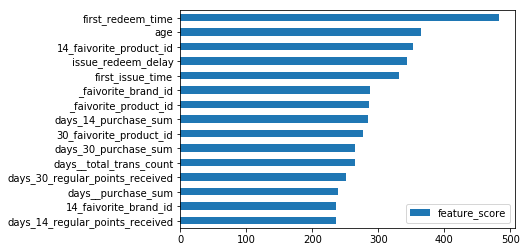

In [40]:
ax = fi.tail(15).plot.barh()